# Test validity step 4 : $P(B_f | ...) \propto -(d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d-B_c s_c) + \eta^t N_c^{1/2} (S_{approx} + E^t (B^T N^{-1} B)^{-1} E) N_c^{1/2} \eta$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import emcee
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import non_parametric_ML_compsep as katame
# from mcmc_tools import *

from jax import config
config.update("jax_enable_x64", True)

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(6, 2, 49152)
(6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


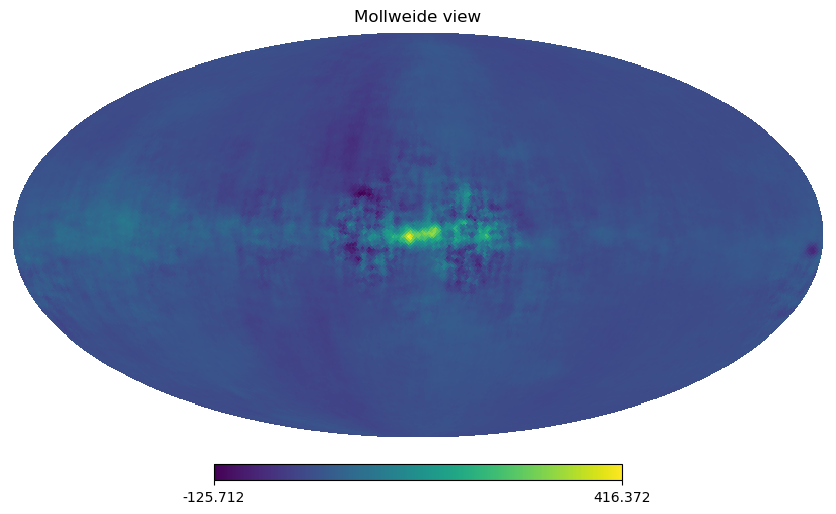

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
nstokes = 2
nside = 64
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

limit_iter_cg=2000
tolerance_CG=10**(-12)

n_iter = 8

number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2

In [6]:
all_spectra = generate_power_spectra_CAMB(nside*2, typeless_bool=True)
lensing_spectra = all_spectra['lensed_scalar'][:lmax+1,:]
camb_cls = all_spectra['total'][:lmax+1,:]

c_ells_input = np.zeros((6,lmax+1))
c_ells_input[:4,...] = camb_cls.T
c_ell_approx = np.zeros((6,lmax+1))
c_ell_approx[1] = camb_cls.T[1]
c_ell_approx[2] = lensing_spectra.T[2]


Calculating spectra from CAMB !


In [7]:
indices_polar = np.array([1,2,4])

if nstokes == 2:    
    c_ells_input = c_ells_input[indices_polar,:]
    c_ell_approx = c_ell_approx[indices_polar,:]
    # CMB_map_input = CMB_map_input[1:,:]
    # freq_maps = freq_maps[:,1:,:]

# CMB covariance preparation
red_cov_approx_matrix = katame.get_reduced_matrix_from_c_ell(c_ell_approx)[lmin:,...]
red_cov_matrix = katame.get_reduced_matrix_from_c_ell(c_ells_input)[lmin:,...]

# Mixing matrix initialization
init_mixing_matrix_obj = katame.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[-1,0])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = katame.MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[-1,0])
# mixing_matrix_obj.update_params(mixing_matrix_obj.params/100)
mixing_matrix_sampled = mixing_matrix_obj.get_B()


# Noise initialization
depth_p = instrument['depth_p']
freq_inverse_noise = katame.get_noise_covar(depth_p, nside)
cp_cp_noise = katame.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = katame.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = katame.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

## Sampling $\eta$ : $P(\eta | ...) \propto \eta^t (S_{approx} + E^t (B^t N^{-1} B)^{-1} E) \eta$

In [8]:
%%time
eta_maps = np.zeros((nstokes, npix))
map_random_x = []
map_random_y = []
eta_maps = katame.get_sampling_eta(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
eta_prime_maps = get_sampling_eta_prime(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)


Recalculating x !
Recalculating y !
CG-Python eta sampling finished in  0 iterations !!
Recalculating x !
Recalculating y !
CPU times: user 546 ms, sys: 110 ms, total: 656 ms
Wall time: 98.8 ms


## Constrained map realization $s_c$ : $P(s_c | ...) \propto (s_c - s_{c,ML})^t (S_c + E^t (B^t N^{-1} B)^{-1} E)^{-1} (s_c - s_{c,ML})$

In [9]:
s_cML = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0,...]

### Fluctuation part

In [10]:
%%time
initial_guess = np.zeros((nstokes,npix))
map_random_realization_xi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
map_random_realization_chi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["number_frequencies"],param_dict["nstokes"],12*param_dict["nside"]**2))
fluctuation_maps = katame.get_fluctuating_term_maps(param_dict, red_cov_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 Fluct finished in  263 iterations !!
CPU times: user 37.3 s, sys: 4.21 s, total: 41.5 s
Wall time: 6.88 s


### Wiener filter part

In [11]:
%%time
initial_guess = np.zeros((nstokes,npix))
wiener_filter_term = katame.solve_generalized_wiener_filter_term(param_dict, s_cML, red_cov_matrix, cp_cp_noise, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 WF finished in  286 iterations !!
CPU times: user 40.6 s, sys: 4.85 s, total: 45.5 s
Wall time: 7.48 s


In [12]:
s_c_map = wiener_filter_term + fluctuation_maps

## Sampling $C$ through inverse Wishart sampling : $P(C | ...) \propto s_c^t C^{-1} s_c + ln|C|$

In [13]:
%%time
c_ells_Wishart = katame.get_cell_from_map(s_c_map, lmax=lmax, n_iter=n_iter)


CPU times: user 115 ms, sys: 16.2 ms, total: 131 ms
Wall time: 35.4 ms


In [14]:
%%time
red_c_ells_inv_Wishart_sample = np.zeros((lmax+1, nstokes, nstokes))
c_ells_inv_Wishart_sample = np.zeros((number_correlations, lmax+1))

red_c_ells_inv_Wishart_sample = katame.get_inverse_wishart_sampling_from_c_ells(np.copy(c_ells_Wishart), l_min=lmin)#[lmin:]
c_ells_inv_Wishart_sample = katame.get_c_ells_from_red_covariance_matrix(red_c_ells_inv_Wishart_sample)

CPU times: user 41.2 ms, sys: 17.7 ms, total: 58.9 ms
Wall time: 12.5 ms


## Few statistics before sampling $\bold{B_f}$ 

## Sampling $\bold{B_f}$ : $P(B_f | ...) \propto -(d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d-B_c s_c) + \eta^t N_c^{1/2} (S_{approx} + E^t (B^T N^{-1} B)^{-1} E) N_c^{1/2} \eta$

In [15]:
s_c_map_extended = np.zeros((number_components, nstokes, npix))
s_c_map_extended[0,...] = s_c_map

full_current_mixing_matrix = mixing_matrix_obj.get_B()

full_data_without_CMB = freq_maps - np.einsum('fc,csp->fsp',full_current_mixing_matrix, s_c_map_extended)

In [16]:
complete_mixing_matrix_fg = mixing_matrix_obj.get_B_fgs()
cp_freq_inv_noise_fg = katame.get_BtinvN(freq_inverse_noise, complete_mixing_matrix_fg)
cp_cp_noise_fg = katame.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix_fg)
print(cp_freq_inv_noise_fg, cp_freq_inv_noise_fg.shape, full_data_without_CMB.shape)

map_fgs = np.einsum('cf,fsp->csp', cp_freq_inv_noise_fg, full_data_without_CMB)
print('d-Bcsc -- mean', np.mean(full_data_without_CMB), 'max', np.max(full_data_without_CMB), 'min', np.min(full_data_without_CMB))
print('B_fN^{-1} (d-Bcsc) - mean', np.mean(map_fgs), 'max', np.max(map_fgs), 'min', np.min(map_fgs))
print('B_fN^{-1} - mean', np.mean(cp_freq_inv_noise_fg), 'max', np.max(cp_freq_inv_noise_fg), 'min', np.min(cp_freq_inv_noise_fg))
print('(B_f^t N^{-1} B_f)^{-1} - mean FG', np.mean(cp_cp_noise_fg), 'max', np.max(cp_cp_noise_fg), 'min', np.min(cp_cp_noise_fg))
print('(B_f^t N^{-1} B_f)^{-1} - mean', np.log(np.linalg.det(cp_cp_noise)))

first_residual = input_cmb_maps[0] - np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0]

[[0.00000000e+00 4.14656112e-02 1.14055148e+01 1.76728994e+01
  1.68138910e+01 5.91561031e+00]
 [1.23312198e+00 6.06937224e+00 1.66943915e+03 2.58680390e+03
  2.46106979e+03 0.00000000e+00]] (2, 6) (6, 2, 49152)
d-Bcsc -- mean 4.052183932089798 max 555.9755079478549 min -316.14231386359387
B_fN^{-1} (d-Bcsc) - mean 8887.07378862576 max 853551.52884099 min -476635.09498959716
B_fN^{-1} - mean 564.7053926654136 max 2586.8039034954245 min 0.0
(B_f^t N^{-1} B_f)^{-1} - mean FG 0.04168632064891228 max 0.16904262077299984 min -0.0011548832558952995
(B_f^t N^{-1} B_f)^{-1} - mean -19.353983849099905


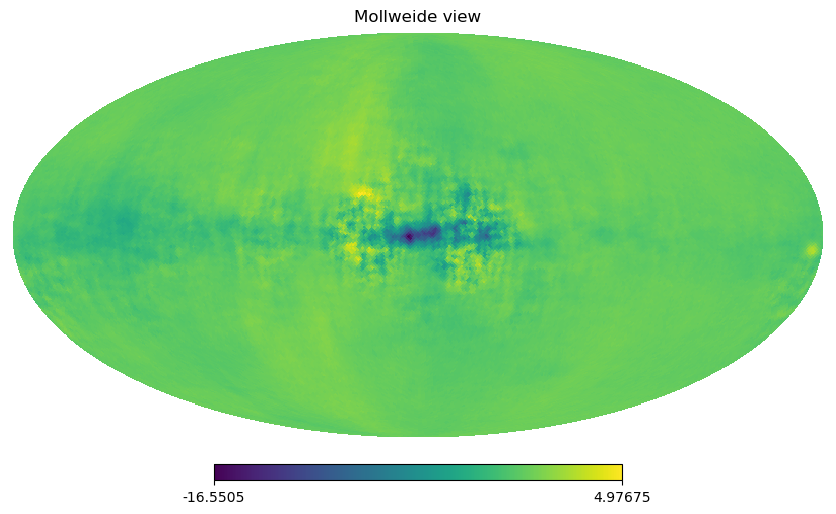

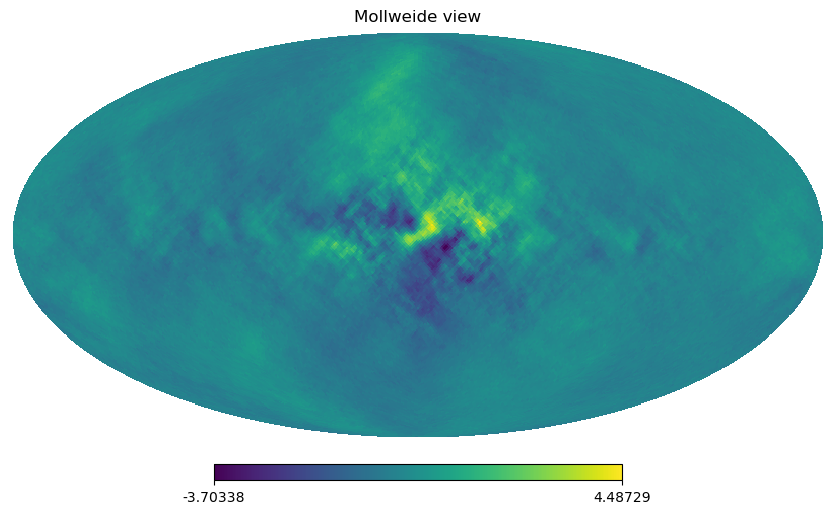

In [17]:
hp.mollview(first_residual[0])
hp.mollview(first_residual[1])

In [18]:
regularization_constant = -1
regularization_factor = 10**10

In [19]:
from functools import partial


In [20]:
# jitted_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX = jax.jit(get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints', 'regularization_constant', 'regularization_factor'])

def new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(params_mixing_matrix, **model_kwargs):
    new_mixing_matrix = jnp.ones((param_dict['number_frequencies'],param_dict['number_components']))
    # new_mixing_matrix[0,1] = 0
    # new_mixing_matrix[-1,-1] = 0
    # new_mixing_matrix[1:,1:-1] = jnp.array(params_mixing_matrix.reshape((param_dict['number_frequencies']-2,param_dict['number_components']-1)))
    new_mixing_matrix = new_mixing_matrix.at[0,1].set(0)
    new_mixing_matrix = new_mixing_matrix.at[-1,-1].set(0)
    new_mixing_matrix = new_mixing_matrix.at[1:-1,1:].set(jnp.array(params_mixing_matrix.reshape((param_dict['number_frequencies']-2,param_dict['number_components']-1))))
    # print("Test ", model_kwargs['with_prints'], flush=True)
    return katame.get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), jnp.array(model_kwargs['eta_prime_maps']), freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=model_kwargs['with_prints'], regularization_constant=regularization_constant, regularization_factor=regularization_factor)

    

In [21]:
%%time

# Calculation value log_proba with current value of B_f

# log_proba = katame.get_conditional_proba_mixing_matrix_foregrounds(mixing_matrix_obj.params, mixing_matrix_obj, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True)
log_proba = new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(mixing_matrix_obj.params, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant, regularization_factor=regularization_factor)
print("Log_proba :", log_proba)
print("<-> Proba :", jnp.exp(log_proba))

CG-Python-0 WF finished in  None iterations !!
Log_proba : -0.7767816720659937
<-> Proba : 0.4598836887263478
CPU times: user 3.78 s, sys: 401 ms, total: 4.19 s
Wall time: 1.48 s


In [22]:
jitted_new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX = jax.jit(new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX, static_argnames=['with_prints'])

In [23]:
%%time

# Calculation value log_proba with current value of B_f
log_proba = jitted_new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(mixing_matrix_obj.params, full_data_without_CMB=full_data_without_CMB, eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant, regularization_factor=regularization_factor)
print("Log_proba :", log_proba)
print("<-> Proba :", jnp.exp(log_proba))

Log_proba : -0.7767816720659937
<-> Proba : 0.4598836887263478
CPU times: user 3.27 s, sys: 597 ms, total: 3.87 s
Wall time: 863 ms


In [24]:
initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel()
dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)
full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.95,high=initial_guess_fg_mixing_matrix*1.05, size=(dimensions_mixing_matrix))

In [25]:
with_prints = False

number_steps_sampler = 1000
n_walkers = 10

kernel = MetropolisHastings(new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX, step_size=0.5)
mcmc = MCMC(kernel, num_chains=n_walkers, num_warmup=0, num_samples=number_steps_sampler)


/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_50572/3170581572.py:7: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_chains=n_walkers, num_warmup=0, num_samples=number_steps_sampler)


In [26]:
initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel()
dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)
full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.95,high=initial_guess_fg_mixing_matrix*1.05, size=(n_walkers,dimensions_mixing_matrix))
# full_initial_guess[0] = np.copy(initial_guess_fg_mixing_matrix)
print(mixing_matrix_obj.params, full_initial_guess)

[[1.21055502e-02 1.77190420e+00]
 [5.16775485e-02 7.56410599e+00]
 [1.29207310e-01 1.89122320e+01]
 [4.40790072e-01 6.45189820e+01]] [[1.24770757e-02 1.83144111e+00 4.97951187e-02 7.46068967e+00
  1.30738764e-01 1.89114278e+01 4.40752040e-01 6.45104646e+01]
 [1.22849438e-02 1.70305549e+00 4.98032395e-02 7.53686385e+00
  1.22905360e-01 1.95346108e+01 4.49005408e-01 6.54008744e+01]
 [1.17142790e-02 1.71455823e+00 5.37174118e-02 7.22457518e+00
  1.32491888e-01 1.81957983e+01 4.32939103e-01 6.17654821e+01]
 [1.20826957e-02 1.81308776e+00 5.35558662e-02 7.60658727e+00
  1.23481065e-01 1.88545935e+01 4.34722901e-01 6.33335701e+01]
 [1.24890937e-02 1.80838212e+00 5.16160867e-02 7.45862331e+00
  1.23737925e-01 1.92101568e+01 4.35097182e-01 6.68705379e+01]
 [1.27030184e-02 1.85733227e+00 5.37609971e-02 7.83038386e+00
  1.32525483e-01 1.91306061e+01 4.44415095e-01 6.19633756e+01]
 [1.20303159e-02 1.83951201e+00 5.39072233e-02 7.88655803e+00
  1.27100444e-01 1.97601087e+01 4.30952539e-01 6.542118

In [27]:
mcmc.run(random.PRNGKey(0), init_params=full_initial_guess, full_data_without_CMB=jnp.array(full_data_without_CMB), eta_prime_maps=jnp.array(eta_prime_maps), freq_inverse_noise=jnp.array(freq_inverse_noise), red_cov_approx_matrix=jnp.array(red_cov_approx_matrix), param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints)
samples = mcmc.get_samples(group_by_chain=False)
mcmc.print_summary()


sample: 100%|██████████| 1000/1000 [18:50<00:00,  1.13s/it]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]     -6.13     10.48     -3.90    -22.21      8.88     12.84      2.46
Param:0[1]      2.71      9.61      3.44    -16.14     14.95     10.10      2.23
Param:0[2]      2.55     12.65      2.55    -19.03     23.68      9.28      2.73
Param:0[3]     13.04      9.56     12.37      1.52     33.20     11.42      2.13
Param:0[4]     -0.70     11.67     -1.12    -13.79     23.76      8.97      2.34
Param:0[5]     22.99      9.44     22.44      4.82     35.62      9.18      2.17
Param:0[6]      3.49      9.80      2.87    -10.82     21.76     11.37      2.54
Param:0[7]     62.02     16.55     63.81     29.96     78.18      6.86      3.16



In [32]:
samples_chain = mcmc.get_samples(group_by_chain=True)

samples_chain.shape

(10, 1000, 8)

In [33]:
ver = 'J1a'
filename_backend_mcmc = "validation_numpyro_step_4_SO_{}ver{}".format(nside,ver)
np.save(filename_backend_mcmc, samples_chain)

In [34]:
chain_samples = mcmc.get_samples(group_by_chain=True)

In [39]:
gelman_rubin_statistic = numpyro.diagnostics.gelman_rubin(chain_samples)
print(gelman_rubin_statistic.shape)
gelman_rubin_statistic

(8,)


array([1.52326483, 1.59953745, 1.74821486, 1.52805812, 1.75790546,
       1.7007734 , 1.58505881, 2.21480138])

In [38]:
gelman_rubin_statistic_0 = numpyro.diagnostics.gelman_rubin(np.mean(chain_samples,axis=2))
print(gelman_rubin_statistic_0.shape)
gelman_rubin_statistic_0

()


1.6893317051686296

In [37]:
gelman_rubin_statistic_2 = numpyro.diagnostics.gelman_rubin(chain_samples[:2])
print(gelman_rubin_statistic_2.shape)
gelman_rubin_statistic_2

(8,)


array([1.90634839, 1.20351607, 1.00168003, 2.13601512, 1.81167314,
       1.00455779, 2.26074361, 1.02509286])

In [ ]:
# old_sample = kernel.init(random.PRNGKey(0), init_params=full_initial_guess, full_data_without_CMB=jnp.array(full_data_without_CMB), eta_prime_maps=jnp.array(eta_prime_maps), freq_inverse_noise=jnp.array(freq_inverse_noise), red_cov_approx_matrix=jnp.array(red_cov_approx_matrix), param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints)


# all_samples = np.zeros((number_steps_sampler, n_walkers, dimensions_mixing_matrix))

# for iteration in range(number_steps_sampler):
#     new_sample = kernel.sample(old_sample, full_data_without_CMB=jnp.array(full_data_without_CMB), eta_prime_maps=jnp.array(eta_prime_maps), freq_inverse_noise=jnp.array(freq_inverse_noise), red_cov_approx_matrix=jnp.array(red_cov_approx_matrix), param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints)

#     old_sample = new_sample


#     # Only check convergence every 100 steps
#     if iteration % 100:
#         continue

#     # Compute the autocorrelation time so far
#     # Using tol=0 means that we'll always get an estimate even
#     # if it isn't trustworthy
#     tau = sample_params_mixing_matrix_FG.get_autocorr_time(tol=0)
#     autocorr[index] = np.mean(tau)
#     index += 1


In [ ]:
samples.shape

(700, 1, 8)

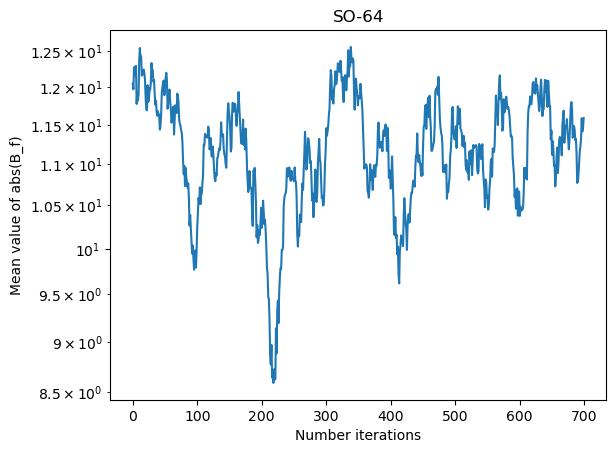

In [ ]:
plt.plot(np.arange(number_steps_sampler), np.abs(samples.mean(axis=(2))))
# plt.plot(np.arange(number_steps_sampler), np.abs(samples.mean(axis=(1,2))))
plt.yscale('log')
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Mean value of abs(B_f)')
plt.show()

In [ ]:
autocorrelation = numpyro.diagnostics.autocorrelation(samples)
autocovariance = numpyro.diagnostics.autocovariance(samples)



In [ ]:
autocorrelation.shape

(700, 1, 8)

In [ ]:
autocovariance.shape

(700, 1, 8)

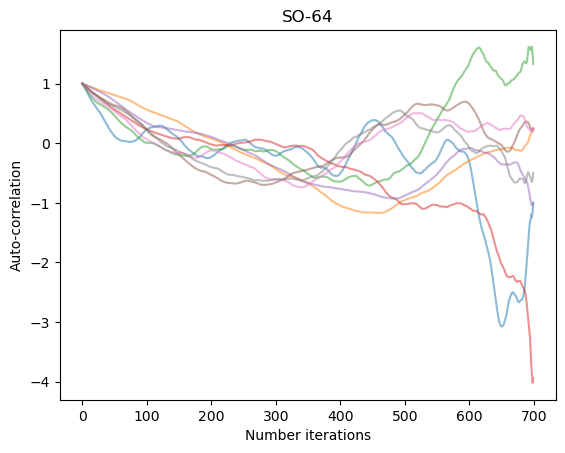

In [ ]:

plt.plot(np.arange(number_steps_sampler), autocorrelation[:,0,:], alpha=.5)
# plt.plot(np.arange(number_steps_sampler), np.mean(autocorrelation[:,0,:],axis=1), 'k')
# plt.loglog()
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Auto-correlation')
plt.show()

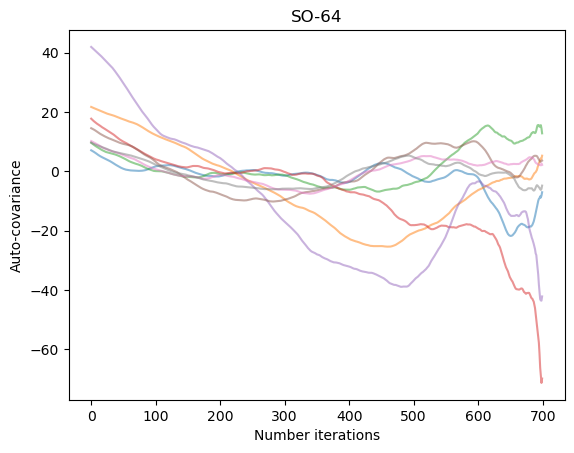

In [ ]:

plt.plot(np.arange(number_steps_sampler), autocovariance[:,0,:], alpha=.5)
# plt.plot(np.arange(number_steps_sampler), np.mean(autocorrelation[:,0,:],axis=1), 'k')
# plt.loglog()
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Auto-covariance')
plt.show()

In [ ]:
autocorrelation_times = np.array([1 + 2*(autocorrelation[i*100:(i+1)*100]/autocorrelation[i*100]).sum(axis=0) for i in range(7)])

In [ ]:
autocorrelation_times

array([[[   63.79095859,   161.09999382,    92.57021867,   118.28840687,
           140.00609   ,   127.25284414,   106.32375782,   124.70962088]],

       [[   36.13165418,   117.98385449, -3269.36898061,    88.14224889,
           128.78817579,  -166.22666612,  -386.79518031,  -109.06069047]],

       [[   57.40231003,  -417.4126455 ,   200.64159748,   -49.771898  ,
          -237.7484772 ,   245.3334249 ,   576.9414696 ,   277.548081  ]],

       [[  252.02666278,   327.10426618,   687.17852401,  2473.33222267,
           311.9451764 ,   135.31273953,   197.66334663,   169.83234917]],

       [[  -22.84121669,   213.27659937,   183.99638445,   331.68981548,
           224.29592965,  -114.16293229,   -55.83473957,  -462.63759895]],

       [[  192.70499288,   140.01772333,  -195.44609265,   204.70822879,
           111.9853972 ,   258.79124916,   194.04872554,    98.90293358]],

       [[ 1272.21949916,    78.94380689,   192.86804936,   358.05416182,
           835.13471414,    55.03

In [ ]:
import emcee.autocorr

In [ ]:
# https://github.com/dfm/emcee/blob/59b6a34323022bc547c3a9fb2173cbffe806af9b/src/emcee/backends/backend.py#L130
emcee.autocorr.integrated_time(samples, tol=0)

array([59.53177363, 85.31270358, 57.24913837, 91.02485449, 81.28128676,
       48.91212108, 53.95907357, 52.25562043])

In [ ]:
# %%time


# # And now sampling B_f using emcee

# n_walkers = 20
# # We have 6*3 parameters to sample, trying to go with 100 steps first
# # number_steps_sampler = 1000
# number_steps_sampler = 700
# with_prints = False

# # whole_chain_samples = katame.sample_mixing_matrix_term(param_dict, mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, red_cov_approx_matrix, freq_inverse_noise, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=10**(-12), n_walkers=n_walkers, number_steps_sampler=number_steps_sampler, with_prints=with_prints)

# initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel()
# dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)

# backend = emcee.backends.HDFBackend(filename_backend_mcmc)
# backend.reset(n_walkers, dimensions_mixing_matrix) # To reset the file !

# # sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, get_conditional_proba_mixing_matrix_foregrounds, args=[mixingmatrix_object, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance, with_prints])
# sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, get_conditional_proba_mixing_matrix_foregrounds, args=[mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance_CG, with_prints], backend=backend)

# # We'll track how the average autocorrelation time estimate changes
# index = 0
# autocorr = np.empty(number_steps_sampler)

# # This will be useful to testing convergence
# old_tau = np.inf

# # Initial guess
# # full_initial_guess = np.random.randn(n_walkers,dimensions_mixing_matrix)
# full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.05,high=initial_guess_fg_mixing_matrix*1.05, size=(n_walkers,dimensions_mixing_matrix))
# full_initial_guess[0] = np.copy(initial_guess_fg_mixing_matrix)

# # final_position_walkers = sample_params_mixing_matrix_FG.run_mcmc(full_initial_guess, number_steps_sampler)

# # Now we'll sample for up to number_steps_sampler steps
# for sample in sample_params_mixing_matrix_FG.sample(full_initial_guess, iterations=number_steps_sampler, progress=True):
#     # Only check convergence every 100 steps
#     if sample_params_mixing_matrix_FG.iteration % 100:
#         continue

#     # Compute the autocorrelation time so far
#     # Using tol=0 means that we'll always get an estimate even
#     # if it isn't trustworthy
#     tau = sample_params_mixing_matrix_FG.get_autocorr_time(tol=0)
#     autocorr[index] = np.mean(tau)
#     index += 1

#     # Check convergence
#     converged = np.all(tau * 100 < sample_params_mixing_matrix_FG.iteration)
#     converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
#     if converged:
#         break
#     old_tau = tau


In [ ]:
mixing_matrix_sampled = last_sample

In [ ]:
cp_cp_noise = katame.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = katame.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = katame.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

residual_post_sampling = input_cmb_maps[0] - np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0]

In [ ]:
hp.mollview(residual_post_sampling[0][0])
hp.mollview(residual_post_sampling[0][1])

## Sample study

In [ ]:
ell_arange = np.arange(c_ells_input.shape[1])

In [ ]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-2
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)